In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from scipy.ndimage.filters import gaussian_filter1d as gaussian
from glob import glob
from scipy.signal import savgol_filter, medfilt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

In [14]:
# 1. load data into pandas data frame

# 2. convert data from I(t) to c_i(t) via equation for G quadruplex binding
    # - find t0
    # - 
# 3. calculate dc_i/dt for each GUV

# 4. calculate background intensity and convert this to c_0(t) via g quadruplex binding model

# 5. plot dc_/dt/A_GUV vs c_0-c_i (expect to see a positive linear relationship)


# as data includes actual G4 background for GUV permeability and later Gramicidin A experiments, start with these experiments


In [2]:
App = 3.16 #um^2

# G quadruplex model binding


def exp_I(c, k = 8.8,A = 0.39):
    return  A+ (1-A)/(k_1*c**2+1)

def inv(I, k = 8.8,A = 0.39):
    
    if I > 1:
        return 0
    
    elif I < A:
        return 1
        
    else:
        return np.sqrt((1/k)*((1-A)/(I-A)-1))


#smoothing configs

sigma = 30




# Calibration model fit


## **If you have already fitted a calibration function and saved the parameters skip this section**


In [4]:
# finding a suitable calibration

calib_data = pd.read_csv('../20210323_KCLFAMG4Q0to20mMCalib/RelIntensG41Concentration.csv')

In [5]:
raw_data = pd.read_csv('../20210323_KCLFAMG4Q0to20mMCalib/1uM/Intensities0-2mM.csv')
n = 512**2

print(raw_data['StdDev']/np.sqrt(n))

dI = raw_data['StdDev']/np.sqrt(n)
drelI = dI/raw_data['Mean']

drelI = drelI*10

rel_errorK = 0.02


0    2.244234
1    2.140793
2    1.921438
3    1.709535
4    1.638162
5    1.617246
Name: StdDev, dtype: float64


In [6]:
%matplotlib qt
I= np.linspace(1,0.2,100)

fig, ax = plt.subplots(1,1)

ax.scatter(calib_data['Rel. Intes'],calib_data['K conc [mM]'],marker = '+',s = 5)

legend = []

# fit a polynomial


fit = np.polyfit(-np.log(calib_data['Rel. Intes'].iloc[:-1]),calib_data['K conc [mM]'].iloc[:-1],3)

def fit_func(I,fit):
    
    c = np.zeros_like(I)
    
    for i in range(1,len(fit)+1):

        c += fit[i-1]*(-np.log(I))**(len(fit)-i)
        print(len(fit)-i)
    return c



ax.plot(I,fit_func(I,fit))

legend.append('Calibration')

def model_fit(cK,kb,c):
    return c + (1-c)/(kb*cK**2+1)

params = curve_fit(model_fit,calib_data['K conc [mM]'],calib_data['Rel. Intes'], p0 = [8.8,0.45])

cK_bar = np.linspace(0,2)
I_bar = model_fit(cK_bar,params[0][0],params[0][1])

ax.set_xlim([0.35,1.05])
ax.plot(I_bar,cK_bar,label = 'Model')
legend.append('Model')

l  = plt.errorbar(calib_data['Rel. Intes'],calib_data['K conc [mM]'],rel_errorK*calib_data['K conc [mM]'],drelI,c = 'k')

ax.set_xticks([0.4,0.6,0.8,1])
ax.set_xticklabels([0.4,0.6,0.8,1],fontsize  = 15)

ax.set_yticks([0,1,2])
ax.set_yticklabels([0,1,2],fontsize = 15)
ax.set_ylim([-0.1,2.1])
plt.tick_params(direction = 'in',top = True,bottom = True,right = True, left = True,length = 5)
ax.set_xlabel('Rel Intensity [a.u]',fontsize = 18)
ax.set_ylabel('[K]/[mM]',fontsize = 18)
l[0].remove()
plt.legend(legend)



3
2
1
0


In [4]:
fit_dict = {'Fitting Params':fit}
df_fit = pd.DataFrame(fit_dict)

df_fit.to_csv('../Calibrations/Calibration_approx_fit_params.csv')

NameError: name 'fit' is not defined

# Load calibration function parameters and define function


In [3]:
fitsdf = pd.read_csv('../Calibrations/Calibration_approx_fit_params.csv')

fit = fitsdf['Fitting Params']

def fit_func(I,fit):
    
    c = np.zeros_like(I)
    
    for i in range(1,len(fit)+1):

        c += fit[i-1]*(-np.log(I))**(len(fit)-i)
        print(len(fit)-i)
    return c

In [4]:

t0 = 0
t1 = 250
t2 = -1
dt = 5/60

In [5]:
# load 260pM Gramicidin A experiment

dfI = pd.read_csv('./collatedIabs20210421OmpF.csv')
dfA = pd.read_csv('./collatedAabs20210421OmpF.csv')

In [6]:
dfI = dfI.iloc[:,1:]
dfA = dfA.iloc[:,1:]

In [7]:
dfA = dfA.fillna(0)
dfI = dfI.fillna(0)

# Remove small detected objects, most likely not GUVs

**check that the size is appropriate for the experiment**

In [8]:
# remove traces for GUVs below a certain area

App = 3.16 #um^2
Amin= 75*App*1e-12 #m^2

for col in dfI.columns:
    
    if col in dfA.columns:
        area = 1e-12*App*np.mean(dfA[col].iloc[:30])
        
        if area < Amin:
            dfI.pop(col)
            dfA.pop(col)

# Remove intensity curves with sudden drops
 These are likely from GUVs suddenly escaping the trap

In [9]:

def remove_burst_events(data,threshold = 0.3):
    
    for column in data.columns:
        
        if len(data[column][data[column] < threshold]) >=1:
            data.pop(column)
            

In [23]:
%matplotlib qt
fig, ax = plt.subplots(1,1)

for col in dfI.columns:
    ax.plot(dfI[col])

In [10]:
# normalise intensities

for col in dfI.columns:
    dfI[col] = dfI[col]/np.mean(dfI[col][:30])
remove_burst_events(dfI)

# Smooth data

## Smoothing strategy

1. In experiments where there was relatively fast decay in intensity initially, but slows down (as exponential decays do..), yet there is still a lot of noise, it may be necessary to smooth different regions with different 'cutoff's.
When the intensity has dropped, the signal to noise drops. What's more during the slower period of intensity decay, there is increasing likelihood that some long timescale event will have happened to distort the data. This long timescale noise may be of a similar timescale to the 'signal' in the early period of rapid decay. 

2. The **solution** chosen here, is to have the user select a timepoint to bisect the time traces. The early period up until that timepoint is smoothed with the 1st user input smoothing parameter (usually between 11-21). Then the later period of slow decay is smoother with much larger smoothing settings (50-80). In order to ensure a smooth 'stitching' of these differently smoothed traces, we concatenate and repeat the smoothing with the smallest of the two specified smoothing parameters.

In [11]:
def smooth_decay(I,t0,t1= -1,t2 = -1,smoothing_0 = 9,smoothing_1 = 51,smoothing_2 = 71):
    
    
    if not  smoothing_0 == 0:
        
        if smoothing_0 > t1-t0 and t1 != -1:
            raise ValueError('Smoothing parameter cannot be greater than input data')

        smoothed_decay_0 = I.iloc[t0:t1]

        smoothed_decay_0 = savgol_filter(smoothed_decay_0,smoothing_0,1)
    else:
        smoothed_decay_0 = I.iloc[t0:t1]
    
    if t1 != -1:
        
        smoothed_decay_1 = I.iloc[t1:t2]
        smoothed_decay_1  = savgol_filter(smoothed_decay_1,smoothing_1,1)
        
        smoothed_decay_1 = np.concatenate((smoothed_decay_0,smoothed_decay_1))
    else:
        smoothed_decay_1 = smoothed_decay_0
   
    if t2 != -1:
        smoothed_decay_2 = I.iloc[t2:]
        smoothed_decay_2  = savgol_filter(smoothed_decay_2,smoothing_2,1)
        smoothed_decay_2 = np.concatenate((smoothed_decay_1,smoothed_decay_2))
        
        
    else:
        smoothed_decay_2 = np.append(smoothed_decay_1,[I.iloc[-1]])
        
    smoothed_decay = smoothed_decay_2
    
    if not smoothing_0 == 0:
        final_smoothed_decay = savgol_filter(smoothed_decay,smoothing_0,1)
    else:
        final_smoothed_decay = smoothed_decay
    return final_smoothed_decay
                                  
                                       
                                    

In [26]:
#Check smoothing still fits data
#
num = 8
fig,axs = plt.subplots(1,num)

for i,col in enumerate(dfI.columns[np.random.randint(0,len(dfI.columns),num)]):
    
    axs[i].plot(dfI[col].iloc[t0:].to_numpy())
    axs[i].plot(smooth_decay(dfI[col],t0,t1))
    

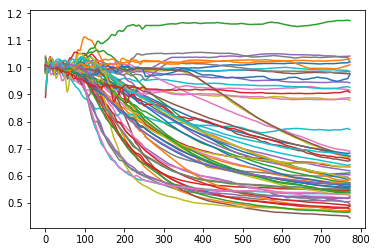

In [12]:
t0_I = 0
smootheddfI = {}
fig, ax = plt.subplots(1,1)

for col in dfI.columns:
    
    smootheddfI[col] = smooth_decay(dfI[col],t0_I,t1,t2)
    
    ax.plot(smootheddfI[col])
    
smootheddfI = pd.DataFrame(smootheddfI)



In [13]:
# filter columns for plotting

keep = []
for col in smootheddfI.columns:
    
    if len(smootheddfI[col].iloc[smootheddfI[col].to_numpy()>1.1]) > 1:
        continue
    elif len(smootheddfI[col].iloc[smootheddfI[col].to_numpy() < 0.75]) < 1:
        continue
    
    keep.append(col)
    
smootheddfI = smootheddfI[keep]

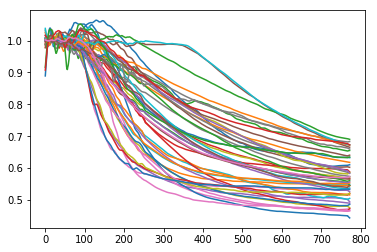

In [14]:
fig, ax = plt.subplots(1,1)
for col in smootheddfI.columns:
    

    
    ax.plot(smootheddfI[col])

In [28]:
active_data = smootheddfI.copy()
# #filter out vesicles that did nothing
# active_data = data.copy()
#


# active_data= active_data.subtract(background[132:],0)

# for column in active_data.keys():
#     active_data[column] = active_data[column]/np.mean(active_data[column][100:110])
#     active_data[column] = active_data[column]
    
#     if np.std(active_data[column]) > 0.5* np.max(active_data[column]):
#         active_data.pop(column)

#     elif len(active_data[column][active_data[column]< 0.4]) > 1:
#         active_data.pop(column)
     
#     elif len(active_data[column][active_data[column]< 0.75]) < 1:
#         active_data.pop(column)
        
#         continue
#     active_data[column] = active_data[column] - background[132:]

# active_data = active_data.subtract(background[132:],0)
    

mean_kinetics = active_data.mean(axis = 1)


std_kinetics = active_data.std(axis = 1)
lower_quantile = active_data.quantile(0.25,axis = 1)
upper_quantile = active_data.quantile(0.75,axis = 1)


In [73]:
print(len(approx_k_conc),len(mean_kinetics))

864 773


In [29]:
n = active_data.shape[1]
deltaCm = approx_k_conc[90:-1] - fit_func(mean_kinetics,fit)
deltaCm_max = approx_k_conc[90:-1]-fit_func(mean_kinetics+std_kinetics/np.sqrt(n),fit)
deltaCm_min = approx_k_conc[90:-1]-fit_func(mean_kinetics-std_kinetics/np.sqrt(n),fit)
J_m = R/3*np.gradient(fit_func(mean_kinetics,fit),dt)/60
J_max = R/3*np.gradient(fit_func(mean_kinetics+std_kinetics/np.sqrt(n),fit),dt)/60
J_min = R/3*np.gradient(fit_func(mean_kinetics-std_kinetics/np.sqrt(n),fit),dt)/60

3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


In [30]:
J_max -J_min

array([ 1.91992579e-09,  1.90866731e-09,  1.87356474e-09,  1.79099714e-09,
        1.56609107e-09,  1.02820495e-09,  2.24740273e-10, -3.53670259e-10,
       -4.98911352e-10, -3.94136318e-10, -3.05480792e-10, -2.11460902e-10,
       -4.38713461e-11,  9.87463396e-11,  1.62364009e-10,  1.78272355e-10,
        1.82971339e-10,  1.73916567e-10,  2.33116668e-10,  2.10429358e-10,
        1.33275974e-10,  1.28868818e-10, -3.13379089e-12, -3.00435677e-10,
       -4.81103365e-10, -4.81682723e-10, -3.51009398e-10, -1.50609206e-10,
       -3.50434240e-11, -2.92412177e-11,  5.11722684e-11,  1.43672419e-10,
        9.06409230e-11, -3.49372518e-11, -1.15092507e-10, -4.12438038e-11,
        7.08000074e-11,  1.01245828e-10,  8.76055195e-11,  1.01393881e-10,
        7.75986050e-11, -2.31388792e-11, -6.91000071e-11, -5.83149810e-11,
       -4.65902222e-11, -7.39611246e-11, -8.01002727e-11, -1.08706931e-10,
       -7.40070226e-11, -1.04338688e-11, -8.30936085e-11, -2.54439084e-10,
       -4.72054901e-10, -

In [35]:
fig, ax = plt.subplots(1,1)

# ax.scatter(deltaCm,J_m)

l = ax.errorbar(deltaCm[90:],J_m[90:],(J_max-J_m)[90:],(deltaCm_max-deltaCm)[90:])
l[0].remove()

In [34]:


ax.scatter(deltaCm[90:],J_m[90:])
ax.set_ylim([-1e-9,11e-9])

(-1e-09, 1.1e-08)

In [32]:
J_mean = pd.DataFrame({'J':J_m[90:]})
deltaC_mean = pd.DataFrame({'dC':deltaCm[90:]})
J_std = pd.DataFrame({'dJ':np.abs(J_max-J_m)[90:]})
std_deltaC = pd.DataFrame({'ddC':np.abs(deltaCm_max[90:]-deltaCm_min[90:])})


In [33]:
J_mean.to_csv('20210421_OmpF_mean_J.csv')
deltaC_mean.to_csv('20210421_OmpF_mean_deltaC.csv')
J_std.to_csv('20210421_OmpF_std_J.csv')
std_deltaC.to_csv('20210421_OmpF_std_deltaC.csv')


# Use calibration inverse to convert I to [K]

In [16]:
dfC_dict = {}

# can't exploit numpy broadcasting

for col in dfI.columns:
    
    smoothed_decay = smooth_decay(dfI[col],t0,t1)
#     print(smoothed_decay)
#     normalised_sd = smoothed_decay/np.mean(smoothed_decay[:30])
    
    cs = []
    for I in smoothed_decay:
#         print(I)
        cs.append(fit_func(I,fit))
    
    
    dfC_dict[col] = cs
    
dfC = pd.DataFrame(dfC_dict)

3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0


0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1


1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2


2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3
2
1
0
3


In [16]:
# filter concentration data by gradient
# if 

fig, axs = plt.subplots(1,2)

for col in dfC.columns:
    
    grad = np.gradient(dfC[col])
    
#     if len(grad[grad <= -0.0009])/len(grad) > 0.05:
#         dfC.pop(col)
#         continue
    axs[0].hist(grad,15)
    axs[1].plot(dfC[col])


In [17]:
tifs = glob('/media/marcus/9C33-6BBD/20210421_OmpF_PCPG_KCl_Exp_1/20210421_OmpF_PCPG_KCl_Exp_1_MMStack_Pos0.ome.tif')
tif = tifs[-1]

vid = tf.TiffFile(tif)

frames = vid.asarray()
bg = np.median(frames[:,447:512,396:440],axis = (1,2))

bg = np.array(bg)-np.mean(bg[-30:-20])
bg = bg/np.max(bg)
bg_k = 1-bg
# make pandas dataframe 

bg= pd.DataFrame({'Bg': bg})
smoothed_bg = smooth_decay(bg['Bg'],0,45,smoothing_0=9,smoothing_1=21)

OME series: invalid TiffData index
OME series: invalid TiffData index


In [18]:
t = np.arange(-100*60,100*60,1)
from scipy.special import erf
# parameters

D1 = 4e-10 #m^2s^-1
D2 = 1e-9 #m^2s^-1

Q = 20e-9/3600 #m^3s-1
A = (30e-6)*(800e-6)
R_tube = 1.5e-3 #m
L_tube = 0.15 #m
V = np.pi*R_tube**2*L_tube

def erf_input(D,k,t_c):
    return (Q*(t-t_c)/A)/(np.sqrt(4*np.pi*k*D*V/Q))
z1 = erf_input(D1,0,1)
z2 = erf_input(D2,0,1)
y1 = 0.5*(1+erf(z1))
y2 = 0.5*(1+erf(z2))

def background(t,k,t_c):
    D = 4e-10 #m^2s^-1
    z = erf_input(D,k,t_c)
    
    return_val = 0.5*(1+erf(z))
    
    return return_val

/home/marcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/marcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [19]:

# estimate the offset time by the 0.5 point time
# the relative diffusion to ideal diffusion constant needs to be estimated with experience

p0 = [0.5,34]

t = dt*np.arange(bg_k.shape[0])

params = curve_fit(background,t,bg_k,p0)



/home/marcus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


In [20]:
t_bar = np.arange(len(frames))
approx_k_conc = background(t_bar,params[0][0],params[0][1])

In [32]:
len(dfC), len(bg_k[30:-1]), len(approx_k_conc),len(frames)

(773, 833, 864, 864)

In [22]:
%matplotlib qt
fig, ax = plt.subplots(1,1)

t_0_record = 90+t0

for col in dfI.columns:
    ax.plot(np.arange(len(dfC[col])),dfC[col])
    
    

ax.plot(np.arange(len(approx_k_conc[t_0_record:-1])),approx_k_conc[t_0_record:-1])

In [13]:
# find representative background concentration variation

# tifs = glob('/media/marcus/9C33-6BBD/20210920_GramA_260pM07_3nM815_1mMKCl_1/260pM/*.tif')

# bgs = []

# fig, ax = plt.subplots(1,1)

# for tif in tifs:
    
#     vid = tf.TiffFile(tif)
    
#     frames = vid.asarray()
    
#     bg = np.median(frames,axis  =(1,2))
#     bg = np.array(bg)/np.max(bg)
#     bgs.append(bg)
    
    
#     ax.plot(bg)

# This confirms that the normalised background is the same for each chamber. Suggesting potassium concs are identical between chambers



In [131]:
# c_bg = []
# for x in bg[360+t0:]:
#     c_bg.append(inv(x))

In [132]:
# fig, axs = plt.subplots(1,2)


# smoothed_background = gaussian(c_bg,sigma)
# axs[0].plot(smoothed_background)
# axs[1].plot(bg[360+t0:])

# Find concentration difference

In [23]:
# calculating c_ext - c_i

dfdeltaC_dict = {}

for col in dfC.columns:
    deltaC = []
    for i in range(len(dfC[col])):
    
        deltaC.append(approx_k_conc[t_0_record:][i]-dfC[col].iloc[i])
    dfdeltaC_dict[col] = deltaC
dfdeltaC = pd.DataFrame(dfdeltaC_dict)# drift in the background intensity over time, once the potassium has arrived, is causing a drifting predicted potassium concentration
# this is unlikely to be the case in reality.
# Therefore the best thing may be to just assume that after an initial 80 frame boundary region (20 mins) for this exp
# the potassium concentration externally reaches 1mM.


In [70]:
dfdeltaC_dict.keys()


dict_keys(['04001', '04002', '04003', '04005', '04006', '03001', '03002', '03003', '03004', '03005', '03006', '03007', '03008', '03009', '03010', '03011', '03012', '03014', '03016', '03017', '03018', '02001', '02002', '02003', '02004', '02005', '02006', '02007', '02008', '02009', '02011', '02012', '02013', '01001', '01002', '01004', '01005', '01006', '01007', '01008', '01009', '01011', '01012', '01014', '01015', '01016', '01017', '01018', '01019', '01020', '01021', '01022', '01023', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00011', '00012', '00013'])

In [33]:
len(dfC[col]),len(approx_k_conc[t_0_record:])

(773, 774)

In [35]:
fig, axC = plt.subplots(1,1)

delete_cols = []

for col in dfdeltaC.columns:
    graddeltaC = np.gradient(dfdeltaC[col])
    
    
#     if len(graddeltaC[graddeltaC > 0]) > 10:
#         delete_cols.append(col)
#         continue
        
    axC.plot(dfdeltaC[col])

In [24]:
fig, axC = plt.subplots(1,1)

delete_cols = []

for col in dfdeltaC.columns:
#     graddeltaC = np.gradient(dfdeltaC[col])
    
    
    if len(dfdeltaC[col][dfdeltaC[col].to_numpy() > 1.]) > 1:
        delete_cols.append(col)
        continue
        
    if  len(dfdeltaC[col][dfdeltaC[col].to_numpy() < 0]) > 1:
        delete_cols.append(col)
        continue
    axC.plot(dfdeltaC[col])
axC.plot(approx_k_conc[t_0_record:-1])

In [25]:
for col in delete_cols:
    dfdeltaC.pop(col)

# Determine the flux

In [26]:
# now calculate J

# J = (1/A)*dN/dt = R/3* dc_i/dt

dfJ_dict = {}


for col in dfdeltaC:
    
    if col in dfA:
        
        delta_c = np.gradient(dfC[col],dt)/60 #molm^-3s^-1
        
        A = np.mean(dfA[col].iloc[:30])*App*1e-12 #m^2
        
        R = np.sqrt(A/np.pi) #m
        
        dfJ_dict[col] = R/3*delta_c #molm^-2s^-1
        

dfJ = pd.DataFrame(dfJ_dict)



In [27]:
fig, ax = plt.subplots(1,1)

for col in dfJ.columns:
    ax.plot(dfJ[col])

# Plot concentration difference


In [88]:
fig, ax = plt.subplots(1,1)

for col in dfJ.columns:

    ax.plot(dt*np.arange(27,len(dfdeltaC[col])),dfdeltaC[col].iloc[27:].to_numpy())

# Plot the Flux against concentration gradient



In [40]:
%matplotlib qt
figJ, axJ = plt.subplots(1,1)
figC, axC = plt.subplots(1,1)
figdC,axdC = plt.subplots(1,1)
t_flux_up =40
t_flux_down = -1
c_threshold = 5e-9

def Jfit(deltac,k,c):
    return k*deltac + c

p0 = [1e-14,0]
Pparams = {}

cols = []
for i,col in enumerate(dfJ.columns):#[np.random.randint(0,len(dfJ.columns),10)]):
    
    
    t = dt*np.arange(0,len(dfdeltaC[col]))
    
    J = dfJ[col]
    J_fit = J.iloc[t_flux_up:t_flux_down]
    deltaC = dfdeltaC[col]
    deltaC_fit = deltaC.iloc[t_flux_up:t_flux_down]
    deltaC_bar = np.linspace(dfC[col].min(),1)
    
#     if len(deltaC.iloc[deltaC.to_numpy().astype(float)>0.9])  <3 :
#         dfJ.pop(col)
#         dfdeltaC.pop(col)
#         continue
    params = curve_fit(Jfit,deltaC_fit,J_fit,p0)
    
    J_bar = Jfit(deltaC_fit,*params[0])
    
    P = params[0][0]
    dP = np.sqrt(params[1][0][0])
    print(dP/P, P)
    
# #     c = params[0][1]
# #     if abs(c) > c_threshold:
# #         dfJ.pop(col)
# #         dfdeltaC.pop(col)
# #         continue
    if P < 0:
        dfJ.pop(col)
        dfdeltaC.pop(col)
        continue
        
    if len(J.iloc[20:].iloc[(deltaC.iloc[20:] < 0.75).to_numpy()]) < 1:
        dfJ.pop(col)
        dfdeltaC.pop(col)
        continue
    
    cols.append(col)
    
    Pparams[col] = params
    
#     print(col)
#    plot fluxes
    axJ.scatter(deltaC[t_flux_up:],J[t_flux_up:],alpha = 0.25)
    axJ.plot(deltaC_fit,J_bar)
#     
    #plot the Intensity vs time
    
    axdC.plot(t,dfdeltaC[col])
    axC.plot(t,dfC[col])
#Flux plot params


axJ.set_xticks([0,0.5,1])
axJ.set_xlim([-0.05,1.05])
axJ.set_xticklabels([0,0.5,1],fontsize = 15)

axJ.set_xlabel('$[K]_{ext} - [K]_{in}$ [mM]',fontsize = 18)
axJ.set_yticks([0,5e-9,1e-8,1.5e-8])
axJ.set_yticklabels([0,5,10,15],fontsize = 15)

axJ.set_ylim([-1e-9,16e-9])
#  
axJ.set_ylabel('J  [$10^{-12}$ mol$m^{-2}s^{-1}$]',fontsize = 18)
axJ.tick_params(direction = 'in',left = True,right = True, top = True, bottom = True,length = 7)

axC.set_xticks([0,20,40])
axC.set_xticklabels([0,20,40],fontsize = 15)
axC.set_xlabel('Time [mins]',fontsize = 18)

axC.set_yticks([0,0.5,1])
axC.set_yticklabels([0,0.5,1],fontsize = 15)
axC.set_ylabel('Rel I',fontsize = 18 )
axC.set_ylim([-0.05,1.05])
axC.set_xlim([-2,45])

# global params

axC.tick_params(direction = 'in',left = True,right = True, top = True, bottom = True,length = 7)


0.4714470028185413 1.8937088018862316e-10
0.023798721948442902 2.739702937688934e-09
0.024886662826659463 4.235137229643265e-09
-0.6125008258518007 -1.3862358249617433e-10
0.030345468818916487 1.068535092532392e-08
0.036093368969137424 1.906911476371129e-09
0.01833837908967913 5.944139057174769e-09
0.02574420891351438 2.1263543356073365e-09
0.03862517505104856 2.2091574794941565e-09
-0.03131796161836705 -1.6327594154152331e-09
0.023492542084737646 1.8403368117812926e-09
0.018926636384119642 4.140655651447785e-09
0.018787696425959895 3.3430733692793797e-09
0.033412434781025936 1.4602826146670813e-09
0.016512959604914723 4.218797651095161e-09
0.03227940533694542 3.0531173663261513e-09
0.05027065367521733 1.9176093788364064e-09
0.019533445071154214 4.3852625213037515e-09
-0.058958570195918214 -8.935905949710647e-10
-0.035780426808627946 -2.132394457180168e-09
0.06205461435036455 8.733432781459475e-10
0.032159446588184225 1.380432270726052e-09
0.03068858481494943 3.043838300388582e-09
0.84

# Save permeability values

In [41]:
P_df = {'P ms^-1': [Pparams[key][0][0] for key in Pparams.keys()],
       'dP/P': [np.sqrt(Pparams[key][1][0][0])/Pparams[key][0][0] for key in Pparams.keys()],
       'A':[np.mean(dfA[key].iloc[:30]) for key in Pparams.keys()]}
        
P_identified = {key:[Pparams[key][0][0]] for key in Pparams.keys()}
P_identified = pd.DataFrame(P_identified)
P_df = pd.DataFrame(P_df)

In [42]:
P_df['P cms^-1'] = P_df['P ms^-1']*100

In [43]:
P_df.to_csv('Permeabilities_OmpF_20210421.csv')

# Save Flux vs deltaC data

In [44]:
dfJ.to_csv('Flux_OmpF_20210421.csv')
dfdeltaC.to_csv('deltaC_OmpF_20210421.csv')
P_identified.to_csv('PbyGUVId_OmpF_20210421.csv')

# Mean J vs Mean concentration difference

Need to bin the concentration differences and then average the flux within each bin


In [45]:
P_identified

,03001,03002,03003,03005,03007,03008,03010,03011,03016,03018,...,01016,01018,01019,01020,01023,00002,00004,00008,00011,00013
0,1.893709e-10,2.739703e-09,4.235137e-09,1.068535e-08,1.906911e-09,5.944139e-09,2.126354e-09,2.209157e-09,1.840337e-09,4.140656e-09,...,1.113221e-09,7.858897e-09,1.430660e-09,2.727619e-09,3.742659e-09,4.893944e-09,1.043020e-08,2.443578e-09,1.931156e-09,4.205035e-09


In [52]:
deltaCbins = np.linspace(0.35,0.95,100)

deltaC_arr = dfdeltaC[cols].to_numpy()

dfJoverP = dfJ[cols]

for col in dfJoverP.columns:
    dfJoverP[col] = dfJoverP[col].to_numpy()/P_identified[col].iloc[0]
    
    
J_arr = dfJoverP.to_numpy()

J_mean = []
deltaC_mean = []
J_scatter = []

for i in range(len(deltaCbins)-1):
    
    deltaC_mean.append(np.median(deltaC_arr[(deltaC_arr < deltaCbins[i+1]) * (deltaC_arr >deltaCbins[i])]))
    J_mean.append(np.median(J_arr[(deltaC_arr < deltaCbins[i+1]) * (deltaC_arr >deltaCbins[i])]))
    J_error = np.std(J_arr[(deltaC_arr < deltaCbins[i+1]) * (deltaC_arr >deltaCbins[i])])
    Ns = np.sum((deltaC_arr < deltaCbins[i+1]) * (deltaC_arr >deltaCbins[i]),axis = 0)
    N = len(Ns[Ns > 1])
    J_scatter.append(J_error/np.sqrt(N))
#     print(len(J_arr[(deltaC_arr < deltaCbins[i+1]) * (deltaC_arr >deltaCbins[i])]))
J_mean = P_identified.iloc[0,:].mean()*np.array(J_mean)
J_mean = np.array(J_mean)

J_scatter = P_identified.iloc[0,:].mean()*np.array(J_scatter)
J_scatter = np.array(J_scatter)

In [50]:
J_mean

array([4.51449123e-10, 2.71622947e-11, 2.35155346e-10, 1.89624303e-10,
       1.39494487e-10, 8.54271759e-11, 2.27615357e-10, 5.06214398e-10,
       2.24213628e-10, 5.14370030e-11, 2.19880424e-10, 1.28111733e-10,
       2.85010104e-10, 4.86322668e-11, 1.42335001e-10, 4.11752116e-10,
       1.29581807e-10, 3.14196294e-10, 3.22899799e-10, 4.58946296e-10,
       4.19850257e-10, 4.98280529e-10, 4.46002793e-10, 3.75869366e-10,
       3.70634160e-10, 4.64206741e-10, 4.87487064e-10, 5.04333008e-10,
       5.91784201e-10, 5.61267565e-10, 6.34580177e-10, 5.16214803e-10,
       6.48830496e-10, 6.09119983e-10, 7.06478009e-10, 7.25421772e-10,
       7.14677589e-10, 7.58944024e-10, 7.44180540e-10, 6.98395006e-10,
       7.23902282e-10, 7.80071564e-10, 7.54848458e-10, 7.71252555e-10,
       7.91503521e-10, 8.58048030e-10, 8.36216117e-10, 8.74618380e-10,
       8.87333767e-10, 9.98676644e-10, 9.80176407e-10, 9.84434399e-10,
       9.75404995e-10, 9.95831632e-10, 1.06544910e-09, 1.04361636e-09,
      

In [53]:
figm,axm = plt.subplots(1,1)


axm.scatter(deltaC_mean,J_mean)
upper_bound = np.array(J_mean) + np.array(J_scatter)
lower_bound = np.array(J_mean) - np.array(J_scatter)
axm.fill_between(deltaC_mean,lower_bound,upper_bound, alpha = 0.25,color = 'g')
axm.set_ylim([-1e-9,16e-9])

(-1e-09, 1.6e-08)

In [79]:
fig, axs = plt.subplots(1,3)
legend = []

for col in dfJ.columns:

    legend.append(col)
#     print(dfdeltaC)

    axs[0].scatter(dfdeltaC[col],dfJ[col]*1e10, marker = '+', s = 10)
    print(dfJ[col])

    axs[1].plot(dt*np.arange(0,len(dfdeltaC[col])),dfdeltaC[col])

    
#     gradients = []
#     win = 10
#     for i in range(dfJ[col].shape[0]-(win-1)):
        
#         gradient = np.mean(np.gradient(dfJ[col].iloc[i:i+win]))
#         gradients.append(gradient)
        
    
    axs[2].plot(np.gradient(dfJ[col],dfdeltaC[col]))
axs[0].tick_params(direction = 'in',left = True,right = True,bottom = True,top = True,length = 6)
axs[1].tick_params(direction = 'in',left = True,right = True,bottom = True,top = True,length = 6)
axs[0].set_xlabel('[K_ext]-[K_int] [mM]',fontsize = 18)

axs[0].set_ylabel('J [molm^-2s^-1]',fontsize = 18)

axs[1].set_ylabel('[K_int] [mM]',fontsize = 18)


axs[1].set_xlabel(' T [mins]',fontsize = 18)



#xticks

axs[0].set_xticks([0.5,0.75,1])
axs[0].set_xticklabels([0.5,0.75,1],fontsize = 15)

axs[1].set_xticks([0,20,40])
axs[1].set_xticklabels([0,20,40],fontsize = 15)

#yticks

axs[0].set_yticks([0,0.005,0.01,0.015])
axs[0].set_yticklabels([0,0.005,0.01,0.015],fontsize = 15)

axs[0].set_ylim([-0.0005,0.0155])
axs[1].set_yticks([0, 0.25,0.5])
axs[1].set_yticklabels([0,0.25,0.5],fontsize = 15)


# plt.rcParams['text.usetex'] = True

# def myticks(x,pos):

#     if x == 0: return "$0$"

#     exponent = int(np.log10(x))
#     coeff = x/10**exponent

#     return r"${:2.0f} \times 10^{{ {:2d} }}$".format(coeff,exponent)

# axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(myticks))

0      1.335491e-10
1      1.335345e-10
2      1.335052e-10
3      1.334760e-10
4      1.334467e-10
5      1.334175e-10
6      1.333882e-10
7      1.333590e-10
8      1.486170e-10
9      2.019091e-10
10     2.254728e-10
11     2.359556e-10
12     3.225050e-10
13     3.899816e-10
14     4.050042e-10
15     4.671642e-10
16     5.006809e-10
17     5.154964e-10
18     5.682043e-10
19     5.162091e-10
20     3.240701e-10
21     2.460612e-10
22     3.229999e-10
23     4.662740e-10
24     5.023994e-10
25     3.694937e-10
26     2.412892e-10
27     1.770229e-10
28     1.559399e-10
29    -1.784628e-11
           ...     
643   -1.089356e-10
644   -1.089532e-10
645   -1.089708e-10
646   -1.089884e-10
647   -1.090060e-10
648   -1.090236e-10
649   -1.090412e-10
650   -1.090588e-10
651   -1.090764e-10
652   -1.090940e-10
653   -1.091116e-10
654   -1.091292e-10
655   -1.091468e-10
656   -1.091644e-10
657   -1.091821e-10
658   -1.091997e-10
659   -1.092173e-10
660   -1.092349e-10
661   -1.092525e-10


/home/marcus/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1069: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/marcus/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:1071: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))


0      1.160257e-09
1      1.158988e-09
2      1.156452e-09
3      1.153918e-09
4      1.151388e-09
5      1.148860e-09
6      1.146334e-09
7      1.143812e-09
8      1.124959e-09
9      1.163488e-09
10     1.218789e-09
11     1.233206e-09
12     1.251856e-09
13     1.211848e-09
14     1.162585e-09
15     1.214375e-09
16     1.265788e-09
17     1.208906e-09
18     1.177116e-09
19     1.105526e-09
20     1.060079e-09
21     1.046213e-09
22     9.696088e-10
23     8.875340e-10
24     8.461404e-10
25     9.145835e-10
26     8.956313e-10
27     8.830232e-10
28     9.851678e-10
29     1.103174e-09
           ...     
643    4.144850e-10
644    4.148913e-10
645    4.152980e-10
646    4.157051e-10
647    4.161127e-10
648    4.165207e-10
649    4.169291e-10
650    4.173380e-10
651    4.177473e-10
652    4.181570e-10
653    4.185672e-10
654    4.189779e-10
655    4.193890e-10
656    4.198005e-10
657    4.202124e-10
658    4.206248e-10
659    4.210377e-10
660    4.214510e-10
661    4.218647e-10


[Text(0, 0, '0'), Text(0, 0, '0.25'), Text(0, 0, '0.5')]

In [54]:
meanFluxdata = {'deltaC':deltaC_mean,'J': J_mean,'semJ':J_scatter}

meanFluxdata = pd.DataFrame(meanFluxdata)

meanFluxdata.to_csv('20210421_OmpF_MeanFluxvsdeltaC.csv')